In [181]:
import pandas as pd
import numpy as np

## データの読み込み

In [182]:
train = pd.read_csv("train.tsv", delimiter='\t', low_memory=True)
test = pd.read_csv("test.tsv", delimiter='\t', low_memory=True)

## データの全体像
train：1,482,535個のユーザーが投稿した商品

test：693,359行で「価格（Price）」の項目がテストデータは含まれていないため、列数は「７」となっている 

* train_id / test _id – ユーザー投稿のID
* name – 投稿のタイトル。タイトルに価格に関する情報がある場合（例：$20）はメルカリが事前に削除をして[rm]と置き換えています。
* item_condition_id – ユーザーが指定した商品の状態(1~5,大きい方が状態が良い)
* category_name – 投稿カテゴリー
* brand_name – ブランドの名前
* price – 訓練データのみ。実際に売られた価格。米ドル表示。今回のチャレンジの予測ターゲットとなります。
* shipping – 送料のフラグ。「1」は販売者負担。「0」は購入者負担。
* item_description – ユーザーが投稿した商品説明の全文。タイトルと同様に価格情報がある場合は[rm]と置き換えられています。

In [183]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


### trainの統計量を表示　transposeで行と列を入れ替え

* train_id：uniqueが0で重複無し
* name：uniqueが多く、商品名が重複している
* brand_name：nameと同じで半分ほど重複している
* price：mean(平均値)が26.7ドル　最小値が0ドル、最大値が2009ドル
* item_description：top(最頻値)はNo description yet(商品説明なし)が82,489個で全体の5.6%

In [184]:
train.describe(include='all').transpose()


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
train_id,1482535.0,NaN,NaN,NaN,741267.0,427971.135004,0.0,370633.5,741267.0,1111900.5,1482534.0
name,1482535,1225273,Bundle,2232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
item_condition_id,1482535.0,NaN,NaN,NaN,1.90738,0.903159,1.0,1.0,2.0,3.0,5.0
category_name,1476208,1287,"Women/Athletic Apparel/Pants, Tights, Leggings",60177,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brand_name,849853,4809,PINK,54088,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,1482535.0,NaN,NaN,NaN,26.737516,38.586066,0.0,10.0,17.0,29.0,2009.0
shipping,1482535.0,NaN,NaN,NaN,0.447274,0.497212,0.0,0.0,0.0,1.0,1.0
item_description,1482529,1281425,No description yet,82489,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 変数ごとの特徴
## Price

In [185]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

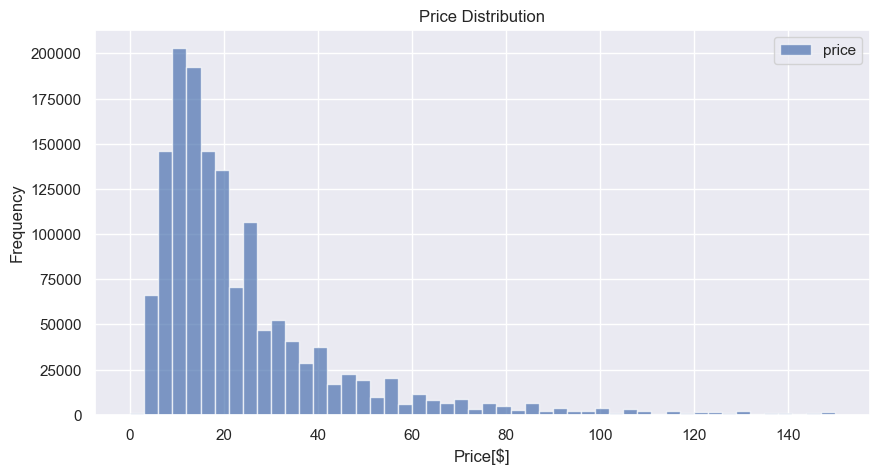

In [186]:
#priceをヒストグラムで表示
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(10, 5))
plt.hist(train.price, bins=50, range=[0, 150], alpha=0.7, color='b', label='price')
plt.title('Price Distribution')
plt.xlabel('Price[$]') 
plt.ylabel('Frequency')
plt.legend()

### 分布が左に偏っているため対数変換して、正規分布にする
分析に使うモデルは出力値の誤差が正規分布に従うと仮定しているので、対数変換してpriceを正規分布に近似させる。

対数変換は、スケール変換と異なり、分布も変化する。これはデータの値が大きいときはその範囲が縮小され、小さいときは拡大されるからである。

つまり、裾の長い分布の範囲を狭めて山型にしたり、極度に集中している分布を押しつぶして裾の長い分布に近づけることが出来る。(今回は後者)

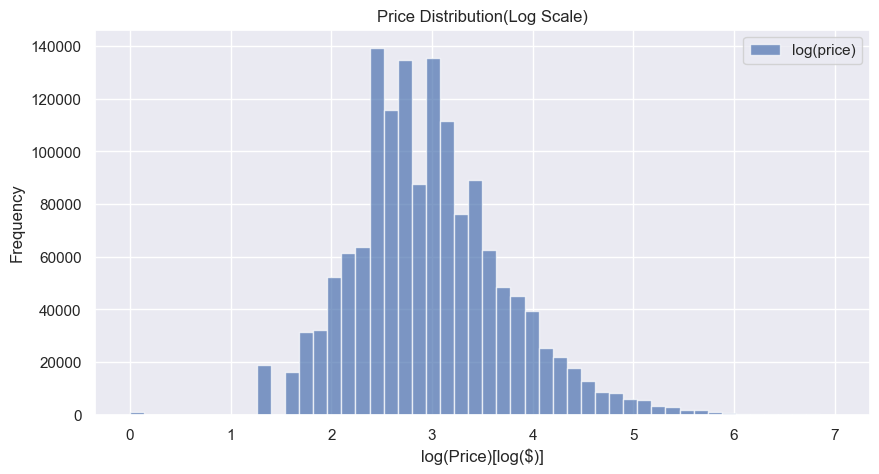

In [187]:
#priceを対数変換してヒストグラムで表示
plt.figure(figsize=(10, 5))
plt.hist(np.log1p(train.price), bins=50, range=[0, 7], alpha=0.7, color='b', label='price')
plt.title('Price Distribution(Log Scale)')
plt.xlabel('log(Price)[log($)]')
plt.ylabel('Frequency')
plt.legend(['log(price)'])

## Shipping

#### 商品の送料の半分以上（55%）は売り手が負担

In [188]:
#shippingの割合を表示 1が販売者負担、0が購入者負担
train.shipping.value_counts() / len(train)

shipping
0    0.552726
1    0.447274
Name: count, dtype: float64

#### 追加の送料分があるから、送料別(買い手負担、赤色のグラフ)の方が安い

/Users/1612h/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 36865 (\N{CJK UNIFIED IDEOGRAPH-9001}) missing from current font.
  func(*args, **kwargs)
/Users/1612h/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 26009 (\N{CJK UNIFIED IDEOGRAPH-6599}) missing from current font.
  func(*args, **kwargs)
/Users/1612h/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 36023 (\N{CJK UNIFIED IDEOGRAPH-8CB7}) missing from current font.
  func(*args, **kwargs)
/Users/1612h/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 12356 (\N{HIRAGANA LETTER I}) missing from current font.
  func(*args, **kwargs)
/Users/1612h/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 25163 (\N{CJK UNIFIED IDEOGRAPH-624B}) missing from current font.
  func(*args, **kwargs)
/Users/1612h/Library/Python/3.9/lib/python/s

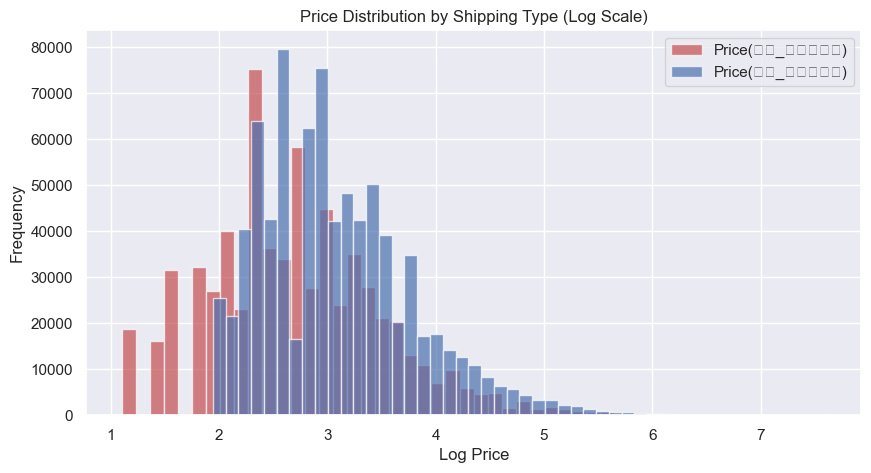

In [189]:
#shippingが売り手負担かどうかでpriceがどう変わるかを確認
plt.figure(figsize=(10, 5))

shipping_fee_by_seller = train.loc[train.shipping==1, 'price']
shipping_fee_by_buyer = train.loc[train.shipping==0, 'price']

# 価格データを対数変換し、0を除外
log_shipping_fee_by_seller = np.log(shipping_fee_by_seller[shipping_fee_by_seller > 0])
log_shipping_fee_by_buyer = np.log(shipping_fee_by_buyer[shipping_fee_by_buyer > 0])

import japanize_matplotlib # 日本語化
plt.hist(log_shipping_fee_by_seller, bins=50, alpha=0.7, color='r', label='Price(送料_買い手負担)')
plt.hist(log_shipping_fee_by_buyer, bins=50, alpha=0.7, color='b', label='Price(送料_売り手負担)')

plt.title('Price Distribution by Shipping Type (Log Scale)')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.legend()

## category_name

女性用の服、美容品が多い

In [190]:
#Top 10のカテゴリを表示 
train.category_name.value_counts()[:10] #[:10]で上位10件を表示 [10:]で下位10件を表示

category_name
Women/Athletic Apparel/Pants, Tights, Leggings                 60177
Women/Tops & Blouses/T-Shirts                                  46380
Beauty/Makeup/Face                                             34335
Beauty/Makeup/Lips                                             29910
Electronics/Video Games & Consoles/Games                       26557
Beauty/Makeup/Eyes                                             25215
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24676
Women/Underwear/Bras                                           21274
Women/Tops & Blouses/Blouse                                    20284
Women/Tops & Blouses/Tank, Cami                                20284
Name: count, dtype: int64

# -------------------- 前処理開始 --------------------

# ----------------- price -----------------

### 3ドル未満のレコードを削除
1,482,535→1,481,661点となり、874の商品が削除された

In [191]:
train = train.drop(train[(train.price < 3.0)].index)
print(train.shape)
print(train["price"].min()) #priceの最小値
print(train["price"].max()) #priceの最大値

(1481661, 8)
3.0
2009.0


# ----------------- category_name -----------------

### general_category, sub_category1, sub_category2 に3等分する

In [192]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label") #categoryがない場合はNo Labelを返す

train['general_cat'], train['sub_cat1'], train['sub_cat2'] = zip(*train['category_name'].apply(lambda x: split_cat(x))) #zip(*df)で転置
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


### testデータも同様に3等分

In [193]:
test['general_cat'], test['sub_cat1'], test['sub_cat2'] = zip(*test['category_name'].apply(lambda x: split_cat(x)))

### 7つのメインカテゴリがあり、女性向けの商品が多い

Text(0, 0.5, 'general category')

/Users/1612h/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20986 (\N{CJK UNIFIED IDEOGRAPH-51FA}) missing from current font.
  func(*args, **kwargs)
/Users/1612h/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 29694 (\N{CJK UNIFIED IDEOGRAPH-73FE}) missing from current font.
  func(*args, **kwargs)
/Users/1612h/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from current font.
  func(*args, **kwargs)
/Users/1612h/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  func(*args, **kwargs)
/Users/1612h/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 21697 (\N{CJK UNIFIED IDEOGRAPH-54C1}) missing from current font.
  func(*args, **kwargs)
/Users/1612h/Library/Python/3.9/lib

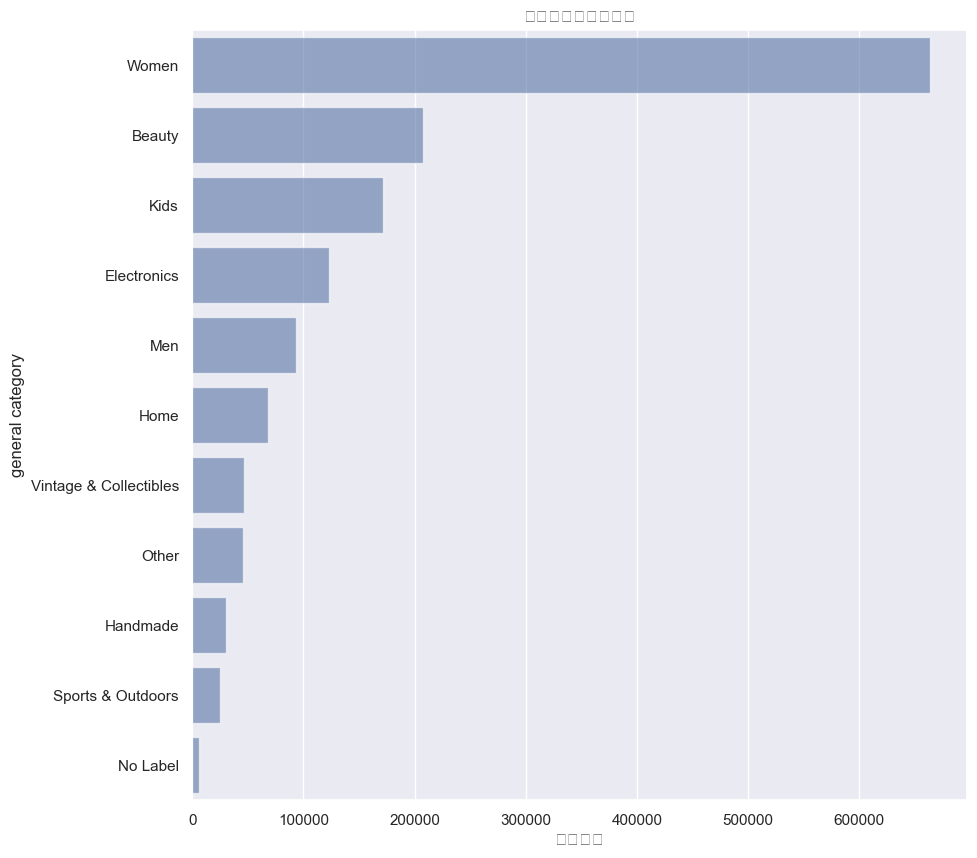

In [194]:
x_general = train['general_cat'].value_counts().index.values.astype('str') #カテゴリ名
y_general = train['general_cat'].value_counts().values #カテゴリの出現回数
pct = [("%.2f"%(v*100))+"%"for v in (y_general/len(train))] #パーセンテージ

plt.figure(figsize=(10,10))
sns.barplot(x=y_general, y=x_general, alpha=0.6)
plt.title("出品カテゴリの分布")
plt.xlabel("出現回数")
plt.ylabel("general category")

### サブカテゴリのうち、Apparel, Make, Topsなどが多い

Text(0, 0.5, 'sub category')

/Users/1612h/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20986 (\N{CJK UNIFIED IDEOGRAPH-51FA}) missing from current font.
  func(*args, **kwargs)
/Users/1612h/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 29694 (\N{CJK UNIFIED IDEOGRAPH-73FE}) missing from current font.
  func(*args, **kwargs)
/Users/1612h/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from current font.
  func(*args, **kwargs)
/Users/1612h/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  func(*args, **kwargs)
/Users/1612h/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 21697 (\N{CJK UNIFIED IDEOGRAPH-54C1}) missing from current font.
  func(*args, **kwargs)
/Users/1612h/Library/Python/3.9/lib

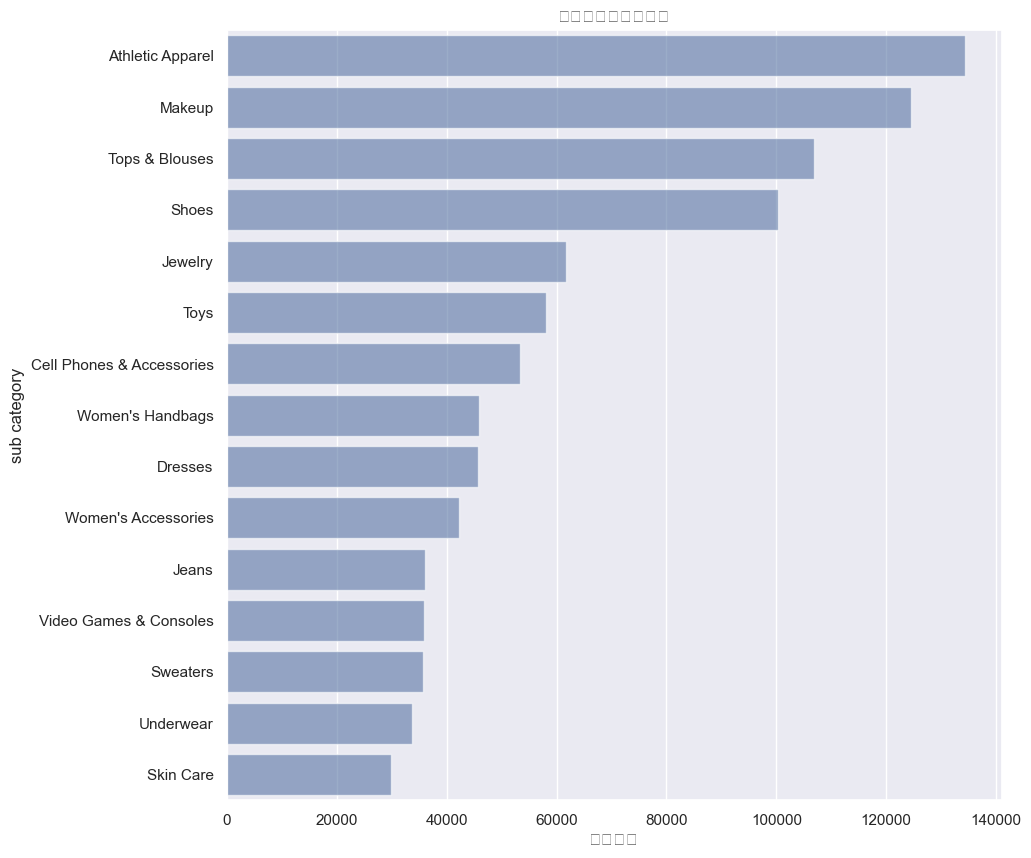

In [195]:
x_sub = train['sub_cat1'].value_counts().index.values.astype('str')[:15]
y_sub = train['sub_cat1'].value_counts().values[:15]
pct = [("%.2f"%(v*100))+"%"for v in (y_sub/len(train))][:15]

plt.figure(figsize=(10,10))
sns.barplot(x=y_sub, y=x_sub, alpha=0.6)
plt.title("出品カテゴリの分布")
plt.xlabel("出現回数")
plt.ylabel("sub category")

object(文字列)のままだと学習ができないため、カテゴリ変数にする

In [196]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [197]:
#general_cat, sub_cat1, sub_cat2をカテゴリ変数に変換
train['general_cat'] = train['general_cat'].astype('category')
train['sub_cat1'] = train['sub_cat1'].astype('category')
train['sub_cat2'] = train['sub_cat2'].astype('category')
train.dtypes

train_id                int64
name                   object
item_condition_id       int64
category_name          object
brand_name             object
price                 float64
shipping                int64
item_description       object
general_cat          category
sub_cat1             category
sub_cat2             category
dtype: object

# ----------------- brand_name -----------------
### 欠損値処理

1. ブランド名の欠損値(NaN)を"missing"に置き換える
2. このままだと欠損値であることに変わりないので、"name(商品名)"が、ブランド名のリストに含まれる場合、ブランド名の"missing"を"name(商品名)"に書き換える

これにより、ブランド名(brand_name)が記載されていない商品でも、商品名(name)からブランド名を取得し、代入することができる

train：1,482,535個の商品

test：693,359個の商品

train_test_combine：2,175,894個の商品

In [198]:
#train,testを縦方向に結合し、まとめて前処理できるようにする
train_test_combine = pd.concat([train,test]) #axis=0で行、axis=1で列に結合 デフォルトはaxis=0
print(train_test_combine.shape)
train_test_combine.head()

(2175020, 12)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2,test_id
0,0.0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,NaN
1,1.0,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,NaN
2,2.0,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,NaN
3,3.0,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,NaN
4,4.0,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,NaN


### 重複なしのブランドリストを作り、欠損値を"missing"に置き換える

In [199]:
#brand_nameの重複なしのリストを作成
brand_name_list = set(train_test_combine["brand_name"].values) #set()で重複を削除

# 'brand_name'の欠損値NaNを'missing'に置き換える
train['brand_name'].fillna(value='missing', inplace=True)
test['brand_name'].fillna(value='missing', inplace=True)

# 訓練データの'brand_name'が'missing'に一致するレコード数を取得
train_premissing = len(train.loc[train['brand_name'] == 'missing'])
# テストデータの'brand_name'が'missing'に一致するレコード数を取得
test_premissing = len(test.loc[test['brand_name'] == 'missing'])

train_premissing, test_premissing #欠損値の数

(632336, 295525)

### 3分ほどかかる

brand_name(trainデータ): 63万点のうち、13.7万点がブランド名を表すデータに書き換えられた

brand_name(testデータ): 29万点のうち、6.4万点がブランド名を表すデータに書き換えられた

In [200]:
def brandfinder(line):
    brand = line[0] # 第1要素はブランド名
    name = line[1]  # 第2要素は商品名
    namesplit = name.split(' ') # 商品名をスペースで切り分ける
    
    if brand == 'missing':  # ブランド名が'missing'の場合
        for x in namesplit: # 商品名から切り分けた単語を取り出す
            if x in brand_name_list: # 単語がブランドリストに存在すればブランド名を返す              
                return name # 単語がブランドリストに一致したら商品名を返す
    if name in brand_name_list:  # 商品名がブランドリストに存在すれば商品名を返す
        return name
    
    return brand            # どれにも一致しなければブランド名を返す

# ブランド名の付替えを実施
train['brand_name'] = train[['brand_name','name']].apply(brandfinder, axis = 1) #axis=1で行方向
test['brand_name'] = test[['brand_name','name']].apply(brandfinder, axis = 1)

# 書き換えられた'missing'の数を取得
train_found = train_premissing-len(train.loc[train['brand_name'] == 'missing'])
test_found = test_premissing-len(test.loc[test['brand_name'] == 'missing'])

print(train_premissing) # 書き換える前の'missing'の数
print(train_found)      # 書き換えられた'missing'の数
print(test_premissing)  # 書き換える前の'missing'の数
print(test_found)       # 書き換えられた'missing'の数

/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_7377/410150371.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  brand = line[0] # 第1要素はブランド名
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_7377/410150371.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  name = line[1]  # 第2要素は商品名
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_7377/410150371.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  br

632336
137342
295525
64154


表の1番目の"brand_name"がmissing → MLB Cincinnatiとなり、missingが"name(商品名)"に書き換えられた

In [201]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,MLB Cincinnati Reds T Shirt Size XL,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [202]:
train.dtypes

train_id                int64
name                   object
item_condition_id       int64
category_name          object
brand_name             object
price                 float64
shipping                int64
item_description       object
general_cat          category
sub_cat1             category
sub_cat2             category
dtype: object

# ----------------- エンコード(文字列→数値データ) -----------------

機械学習ではカテゴリ変数(name, category_name, brand_name, item_description)を文字列ではなく、数値型に変換する必要がある

### name, category_name, brand_name, item_descriptionの欠損値(NaN)を"missing"で埋める

In [203]:
# train,testをそれぞれ変換するのは面倒なので、train_test_combineで一括変換
train_test_combine = pd.concat([train, test])

#fillnaで欠損値を埋める
train_test_combine['name'].fillna(value='missing', inplace=True)
train_test_combine['category_name'].fillna(value='missing', inplace=True)
train_test_combine['general_cat'].fillna(value='missing', inplace=True)
train_test_combine['sub_cat1'].fillna(value='missing', inplace=True)
train_test_combine['sub_cat2'].fillna(value='missing', inplace=True)
train_test_combine['brand_name'].fillna(value='missing', inplace=True)
train_test_combine['item_description'].fillna(value='missing', inplace=True)

### name, item_descriptionはトークンに分解してからエンコードするため、一旦放置

下の表でわかるように文字列がすべて数値データに変換された

test_idがNaNだけど、気にしなくていいや

In [204]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

#カテゴリ変数を数値に変換
# train_test_combine['name'] = le.fit_transform(train_test_combine['name'])
train_test_combine['category_name'] = le.fit_transform(train_test_combine['category_name'])
train_test_combine['general_cat'] = le.fit_transform(train_test_combine['general_cat'])
train_test_combine['sub_cat1'] = le.fit_transform(train_test_combine['sub_cat1'])
train_test_combine['sub_cat2'] = le.fit_transform(train_test_combine['sub_cat2'])
train_test_combine['brand_name'] = le.fit_transform(train_test_combine['brand_name'])
# train_test_combine['item_description'] = le.fit_transform(train_test_combine['item_description'])

train_test_combine.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2,test_id
0,0.0,MLB Cincinnati Reds T Shirt Size XL,3,829,99781,10.0,1,No description yet,5,103,774,NaN
1,1.0,Razer BlackWidow Chroma Keyboard,3,86,133889,52.0,0,This keyboard is in great condition and works ...,1,30,215,NaN
2,2.0,AVA-VIV Blouse,1,1277,154438,10.0,1,Adorable top with a hint of lace and a key hol...,10,104,97,NaN
3,3.0,Leather Horse Statues,1,503,177922,35.0,1,New with tags. Leather horses. Retail for [rm]...,3,55,410,NaN
4,4.0,24K GOLD plated rose,1,1204,177922,44.0,0,Complete with certificate of authenticity,10,58,542,NaN


## name, item_descriptionをエンコード(自然言語処理)
### 2分ほどかかる
name, item_descriptionは複数の単語で構成されるので、単純なエンコード(数値変換)ではなく、KerasのTokenizerクラスを使ってエンコード

Tokenizerとは

* 英文のテキストデータをトークン(最小単位)に分解する
* 各トークンに通し番号(インデックス)を割り振ることで実数ベクトルに変換する

分かりやすいzenn記事：https://zenn.dev/robes/articles/b6708032855a9c

In [205]:
from tensorflow.keras.preprocessing.text import Tokenizer

print("Transforming text data to sequences...")
raw_text = np.hstack(
    [train_test_combine.item_description.str.lower(), # 説明文
     train_test_combine.name.str.lower()]           # 商品名
)
print('sequences shape', raw_text.shape)

# 説明文、商品名、カテゴリ名を連結した配列でTokenizerを作る
print("   Fitting tokenizer...")
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)

# Tokenizerで説明文、商品名をそれぞれラベルエンコードする
print("   Transforming text to sequences...")
train_test_combine['seq_item_description'] = tok_raw.texts_to_sequences(train_test_combine.item_description.str.lower())
train_test_combine['seq_name'] = tok_raw.texts_to_sequences(train_test_combine.name.str.lower())

del tok_raw #delは変数を削除する

print(train_test_combine.seq_item_description.head())
print(train_test_combine.seq_name.head())

Transforming text data to sequences...
sequences shape (4350040,)
   Fitting tokenizer...
   Transforming text to sequences...
0                                         [12, 68, 79]
1    [29, 2666, 10, 7, 38, 17, 1, 206, 51, 19, 1099...
2    [597, 60, 9, 4, 5351, 11, 192, 1, 4, 900, 1299...
3    [5, 9, 61, 178, 6621, 229, 3, 21, 166, 1086, 2...
4                             [801, 9, 7022, 11, 2013]
Name: seq_item_description, dtype: object
0    [3882, 8986, 6977, 208, 84, 6, 155]
1            [11402, 27914, 17350, 2666]
2                     [7811, 10858, 666]
3                     [178, 2603, 14008]
4                 [4962, 103, 1032, 280]
Name: seq_name, dtype: object


### 0でパディング(埋める)して配列の長さを揃える

自然言語処理の学習における入力データは固定長化する必要がある

参考サイト；https://moneyforward-dev.jp/entry/2021/10/05/transformers-tokenizer/

In [206]:
from keras.preprocessing.sequence import pad_sequences
print(pad_sequences(train_test_combine.seq_item_description, maxlen=80),'\n') # 商品説明
print(pad_sequences(train_test_combine.seq_name, maxlen=10))                  # 商品名

[[    0     0     0 ...    12    68    79]
 [    0     0     0 ...    14    49   996]
 [    0     0     0 ...   175     7    59]
 ...
 [    0     0     0 ...    20 63502    88]
 [    0     0     0 ...     4   369    71]
 [    0     0     0 ...     4   593   635]] 

[[    0     0     0 ...    84     6   155]
 [    0     0     0 ... 27914 17350  2666]
 [    0     0     0 ...  7811 10858   666]
 ...
 [    0     0     0 ...   401  1559    88]
 [    0     0     0 ...   325   281  2230]
 [    0     0     0 ...   892   725    69]]


In [207]:
train_test_combine.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2,test_id,seq_item_description,seq_name
0,0.0,MLB Cincinnati Reds T Shirt Size XL,3,829,99781,10.0,1,No description yet,5,103,774,NaN,"[12, 68, 79]","[3882, 8986, 6977, 208, 84, 6, 155]"
1,1.0,Razer BlackWidow Chroma Keyboard,3,86,133889,52.0,0,This keyboard is in great condition and works ...,1,30,215,NaN,"[29, 2666, 10, 7, 38, 17, 1, 206, 51, 19, 1099...","[11402, 27914, 17350, 2666]"
2,2.0,AVA-VIV Blouse,1,1277,154438,10.0,1,Adorable top with a hint of lace and a key hol...,10,104,97,NaN,"[597, 60, 9, 4, 5351, 11, 192, 1, 4, 900, 1299...","[7811, 10858, 666]"
3,3.0,Leather Horse Statues,1,503,177922,35.0,1,New with tags. Leather horses. Retail for [rm]...,3,55,410,NaN,"[5, 9, 61, 178, 6621, 229, 3, 21, 166, 1086, 2...","[178, 2603, 14008]"
4,4.0,24K GOLD plated rose,1,1204,177922,44.0,0,Complete with certificate of authenticity,10,58,542,NaN,"[801, 9, 7022, 11, 2013]","[4962, 103, 1032, 280]"


## name, item_descriptionの単語数をカウントした列を追加

単語数が多いと価格も高い？

In [208]:
def wordCount(text):
    """
    Parameters:
      text(str): 商品名、商品の説明文
    """
    try:
        if text == 'No description yet':
            return 0  # 商品名や説明が'No description yet'の場合は0を返す
        else:
            text = text.lower()                  # すべて小文字にする
            words = [w for w in text.split(" ")] # スペースで切り分ける
            return len(words)                    # 単語の数を返す
    except: 
        return 0

# 'name'の各フィールドの単語数を'name_len'に登録
train_test_combine['name_len'] = train_test_combine['name'].apply(lambda x: wordCount(x))
# 'item_description'の各フィールドの単語数を'desc_len'に登録
train_test_combine['desc_len'] = train_test_combine['item_description'].apply(lambda x: wordCount(x))

In [209]:
train_test_combine.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2,test_id,seq_item_description,seq_name,name_len,desc_len
0,0.0,MLB Cincinnati Reds T Shirt Size XL,3,829,99781,10.0,1,No description yet,5,103,774,NaN,"[12, 68, 79]","[3882, 8986, 6977, 208, 84, 6, 155]",7,0
1,1.0,Razer BlackWidow Chroma Keyboard,3,86,133889,52.0,0,This keyboard is in great condition and works ...,1,30,215,NaN,"[29, 2666, 10, 7, 38, 17, 1, 206, 51, 19, 1099...","[11402, 27914, 17350, 2666]",4,36
2,2.0,AVA-VIV Blouse,1,1277,154438,10.0,1,Adorable top with a hint of lace and a key hol...,10,104,97,NaN,"[597, 60, 9, 4, 5351, 11, 192, 1, 4, 900, 1299...","[7811, 10858, 666]",2,29
3,3.0,Leather Horse Statues,1,503,177922,35.0,1,New with tags. Leather horses. Retail for [rm]...,3,55,410,NaN,"[5, 9, 61, 178, 6621, 229, 3, 21, 166, 1086, 2...","[178, 2603, 14008]",3,32
4,4.0,24K GOLD plated rose,1,1204,177922,44.0,0,Complete with certificate of authenticity,10,58,542,NaN,"[801, 9, 7022, 11, 2013]","[4962, 103, 1032, 280]",4,5


In [210]:
train_test_combine.dtypes

train_id                float64
name                     object
item_condition_id         int64
category_name             int64
brand_name                int64
price                   float64
shipping                  int64
item_description         object
general_cat               int64
sub_cat1                  int64
sub_cat2                  int64
test_id                 float64
seq_item_description     object
seq_name                 object
name_len                  int64
desc_len                  int64
dtype: object

### name, item_descriptionが文字列なのでカテゴリ変数に変換

In [211]:
# 文字列(object)カテゴリー変数に変換
train_test_combine['name'] = train_test_combine['name'].astype('category')
train_test_combine['item_description'] = train_test_combine['item_description'].astype('category')

### seq_item_description, seq_nameはリスト型なので、一旦文字列に変換してからカテゴリ変数にする

In [212]:
# 文字列(object)カテゴリー変数に変換
train_test_combine['name'] = train_test_combine['name'].astype('category')
train_test_combine['item_description'] = train_test_combine['item_description'].astype('category')

# リストを文字列に変換してからカテゴリー変数に変換
train_test_combine['seq_item_description'] = train_test_combine['seq_item_description'].apply(lambda x: str(x)).astype('category')
train_test_combine['seq_name'] = train_test_combine['seq_name'].apply(lambda x: str(x)).astype('category')

In [213]:
train_test_combine.dtypes

train_id                 float64
name                    category
item_condition_id          int64
category_name              int64
brand_name                 int64
price                    float64
shipping                   int64
item_description        category
general_cat                int64
sub_cat1                   int64
sub_cat2                   int64
test_id                  float64
seq_item_description    category
seq_name                category
name_len                   int64
desc_len                   int64
dtype: object

## priceを対数変換して正規化して、"target"列を追加

In [214]:
# 訓練データの'price'を対数変換する
target = np.log1p(train.price)

## 前処理後の結合したデータ(train_test_combine)を再びtrain,testデータに分割する

train：1,482,535点

test：693,359点

testデータにはprice列が与えられていなかったため、1列少ないはずだがNaNで埋めたため、testと同じ16列となっている

In [215]:
#train_test_combineからtrainとtestに分割
train = train_test_combine[:len(train)]
test = train_test_combine[len(train):]
print(train_test_combine.shape)
print(train.shape)
print(test.shape)

(2175020, 16)
(1481661, 16)
(693359, 16)


In [216]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2,test_id,seq_item_description,seq_name,name_len,desc_len
0,0.0,MLB Cincinnati Reds T Shirt Size XL,3,829,99781,10.0,1,No description yet,5,103,774,NaN,"[12, 68, 79]","[3882, 8986, 6977, 208, 84, 6, 155]",7,0
1,1.0,Razer BlackWidow Chroma Keyboard,3,86,133889,52.0,0,This keyboard is in great condition and works ...,1,30,215,NaN,"[29, 2666, 10, 7, 38, 17, 1, 206, 51, 19, 1099...","[11402, 27914, 17350, 2666]",4,36
2,2.0,AVA-VIV Blouse,1,1277,154438,10.0,1,Adorable top with a hint of lace and a key hol...,10,104,97,NaN,"[597, 60, 9, 4, 5351, 11, 192, 1, 4, 900, 1299...","[7811, 10858, 666]",2,29
3,3.0,Leather Horse Statues,1,503,177922,35.0,1,New with tags. Leather horses. Retail for [rm]...,3,55,410,NaN,"[5, 9, 61, 178, 6621, 229, 3, 21, 166, 1086, 2...","[178, 2603, 14008]",3,32
4,4.0,24K GOLD plated rose,1,1204,177922,44.0,0,Complete with certificate of authenticity,10,58,542,NaN,"[801, 9, 7022, 11, 2013]","[4962, 103, 1032, 280]",4,5


In [217]:
test.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2,test_id,seq_item_description,seq_name,name_len,desc_len
0,NaN,"Breast cancer ""I fight like a girl"" ring",1,1205,177922,NaN,1,Size 7,10,58,667,0.0,"[6, 64]","[1789, 3475, 15, 5555, 51, 4, 266, 263]",8,2
1,NaN,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,899,177922,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",7,72,701,1.0,"[439, 802, 5, 64, 34, 9038, 5187, 616, 1024, 7...","[439, 802, 5, 64, 34, 9038, 5187, 616, 1024]",7,38
2,NaN,Coach bag,1,1000,39455,NaN,1,Brand new coach bag. Bought for [rm] at a Coac...,9,7,382,2.0,"[16, 5, 315, 101, 201, 3, 21, 107, 4, 315, 3689]","[315, 101]",2,11
3,NaN,Floral Kimono,2,1256,177922,NaN,0,-floral kimono -never worn -lightweight and pe...,10,97,166,3.0,"[281, 2230, 37, 30, 577, 1, 93, 3, 350, 1844]","[281, 2230]",2,10
4,NaN,Life after Death,3,860,177922,NaN,1,Rediscovering life after the loss of a loved o...,7,14,662,4.0,"[98827, 473, 286, 2, 1504, 11, 4, 1093, 46, 10...","[473, 286, 5470]",3,29


### カテゴリ変数(category)だとモデルの学習ができなかったので、数値(int)に変換

In [224]:
# name, item_description, seq_item_description, seq_name, name_len, desc_lenを数値に変換
train['name'] = le.fit_transform(train['name'])
train['item_description'] = le.fit_transform(train['item_description'])
test['name'] = le.fit_transform(test['name'])
test['item_description'] = le.fit_transform(test['item_description'])
train['seq_item_description'] = le.fit_transform(train['seq_item_description'])
train['seq_name'] = le.fit_transform(train['seq_name'])
train['name_len'] = le.fit_transform(train['name_len'])
train['desc_len'] = le.fit_transform(train['desc_len'])

/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_7377/425673985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['name'] = le.fit_transform(train['name'])
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_7377/425673985.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['item_description'] = le.fit_transform(train['item_description'])
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_7377/425673985.py:4: SettingWithCopyWarning: 
A value is trying to be set on a co

In [225]:
train.dtypes

train_id                float64
name                      int64
item_condition_id         int64
category_name             int64
brand_name                int64
price                   float64
shipping                  int64
item_description          int64
general_cat               int64
sub_cat1                  int64
sub_cat2                  int64
test_id                 float64
seq_item_description      int64
seq_name                  int64
name_len                  int64
desc_len                  int64
dtype: object

# -------------------- 前処理終了 --------------------

# モデルの作成と学習

### trainデータのうち、7割を訓練用(train)、3割を検証用(val)に分割する

本に載ってた99:1は極端すぎる、一般的には7:3

In [226]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train, target, test_size=0.3)

In [236]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNet, Ridge

# 文字列データを数値データに変換
label_encoders = {}
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        le = LabelEncoder()
        X_train[column] = le.fit_transform(X_train[column].astype(str))
        X_val[column] = le.transform(X_val[column].astype(str))
        label_encoders[column] = le

# NaN値を平均値で埋める
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

/Users/1612h/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['test_id']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/1612h/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['test_id']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


## モデルの学習に4分ほどかかる

In [237]:
## RMSLEの評価関数
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(np.log(y_pred[i] + 1) - np.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

# モデルの学習
model = Ridge(solver="sag", fit_intercept=True, random_state=205, alpha=3)
model.fit(X_train_imputed, y_train)

/Users/1612h/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Ridge(alpha=3, random_state=205, solver='sag')

In [243]:
from sklearn.metrics import mean_squared_log_error

# RMSLE関数の定義
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# モデルの評価
y_pred = model.predict(X_val_imputed)
print("RMSLE: ", rmsle(np.expm1(y_val), np.expm1(y_pred)))

RMSLE:  0.5558444608490906
